<a href="https://colab.research.google.com/github/VictorZwart/ScriptieOffensiveLanguage/blob/main/BiLSTM%26CNN/scriptie_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Thesis code for BiLSTM and CNN
Author: Victor Zwart\
Date: 26/05/2021



Based on the following tutorials:\
 

*   CNN: https://medium.com/voice-tech-podcast/text-classification-using-cnn-9ade8155dfb9
*   BiLSTM: https://www.kaggle.com/alexcherniuk/imdb-review-word2vec-bilstm-99-acc



In [1]:
# get gpu specs
!nvidia-smi
# Tesla K80 (11441MiB) = bad
# Tesla T4  (15109MiB) = good


Wed May 26 11:53:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import
First import all the necessary packages

In [8]:
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences

#BiLSTM imports:
from sklearn.model_selection import train_test_split
from keras.layers import Dense, LSTM, Dropout, Bidirectional

# Modules for data manipulation
import numpy as np
import pandas as pd
import re
import csv

import urllib
import shutil
import sys
from sklearn.model_selection import train_test_split


# Modules for visualization
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import confusion_matrix, classification_report


import tensorflow as tf



In [6]:
# Needed for the initilisation of the coosto word embedding model
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# upload data
from google.colab import files
train_upload = files.upload()
dev_upload = files.upload()
test_upload= files.upload()
print(test_upload)
print(train_upload)

Saving train_final.csv to train_final.csv


Saving dev_final.csv to dev_final.csv


Saving test_final.csv to test_final.csv


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16
LARGE_SIZE = 20

params = {
    'figure.figsize': (16, 8),
    'font.size': SMALL_SIZE,
    'xtick.labelsize': MEDIUM_SIZE,
    'ytick.labelsize': MEDIUM_SIZE,
    'legend.fontsize': BIG_SIZE,
    'figure.titlesize': LARGE_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': BIG_SIZE
}
plt.rcParams.update(params)

Import Data

In [10]:
def preprocess(line):
    # first lowercase:
    line = line.lower()

    #remove mentions:
    line = re.sub(r'(@\w+)','MENTION', line)

    #remove url's:
    line = re.sub(r'(https\S+)','URL',line)

    #remove all numbers
    line  = re.sub(r'[0-9]+', 'NUMBER', line)

    #remove all hashtags
    line  = re.sub(r'#', '', line)


    return line

input = '@arieboomsma Ik heb je 12 stukken gelezen #Indrukwekkend maar https://t.co/NQMxvgXXW6 vertel @arieboomsma dat ook even tegen de nabestaanden in #Parijs en tegen de andere slachtoffers https://t.co/NQMxvgXXW6'
print(preprocess(input))

MENTION ik heb je NUMBER stukken gelezen indrukwekkend maar URL vertel MENTION dat ook even tegen de nabestaanden in parijs en tegen de andere slachtoffers URL


In [13]:
# Function to get the data with the goal, being either 'target' or 'explicitness'

def get_data(file_name):
    """
    file_name string: File name of the file to read 

    returns df_full: a pandas dataframe with explicitness, text and target
    """
    offensiveness = ['NOT', 'EXPLICIT', 'IMPLICIT']
    full_data = []
    with open(file_name, encoding='utf-8') as f:
        reader = csv.DictReader(f, delimiter='\t')
        for index, line in enumerate(reader):
            text = preprocess(line['text'])
            full_data.append([text, line['explicitness'], line["target"]])

    df_full = pd.DataFrame(full_data)    
    df_full.columns = ["text", "explicitness", "target"]
    df_full = df_full[df_full.explicitness != '']
    df_full = df_full.dropna(subset=['explicitness'])
    print("  Total: {} tweets read".format(len(df_full)))
    return df_full


In [14]:
print("\n##### Reading training data:")
train_exp = get_data('train_final.csv')
print("\n##### Reading development data:")
dev_exp = get_data('dev_final.csv')
print("\n##### Reading test data:")
test_exp = get_data('test_final.csv')

df_full_exp = [train_exp, test_exp]
train_target = train_exp[train_exp.explicitness != 'NOT']
test_target = test_exp[test_exp.explicitness != 'NOT']


##### Reading training data:
  Total: 7764 tweets read

##### Reading development data:
  Total: 547 tweets read

##### Reading test data:
  Total: 3108 tweets read


# Visualisation of the data

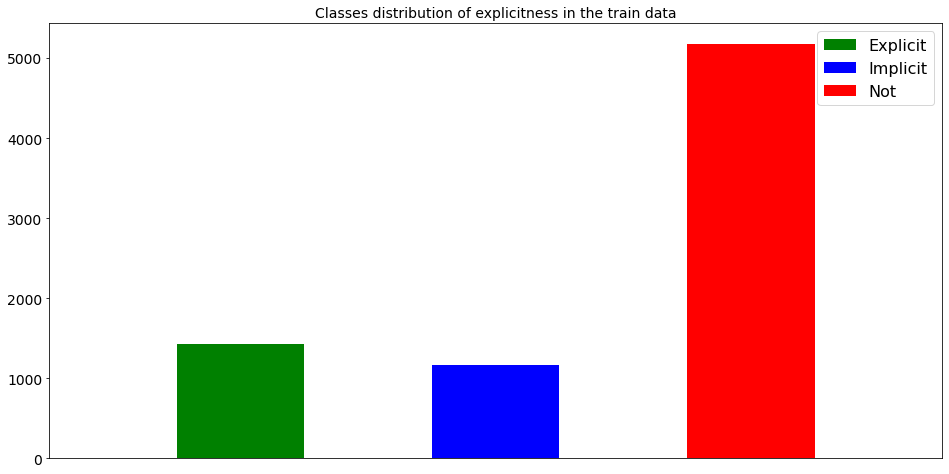

In [15]:
#plot of explicitness
plt.hist(train_exp[train_exp.explicitness == "EXPLICIT"].explicitness,
         bins=2, color='green', label='Explicit')
plt.hist(train_exp[train_exp.explicitness == "IMPLICIT"].explicitness,
         bins=2, color='blue', label='Implicit')
plt.hist(train_exp[train_exp.explicitness == "NOT"].explicitness,
         bins=2, color='red', label='Not')
plt.title('Classes distribution of explicitness in the train data')
plt.xticks([])
plt.xlim(-0.5, 3)
plt.legend()
plt.show()

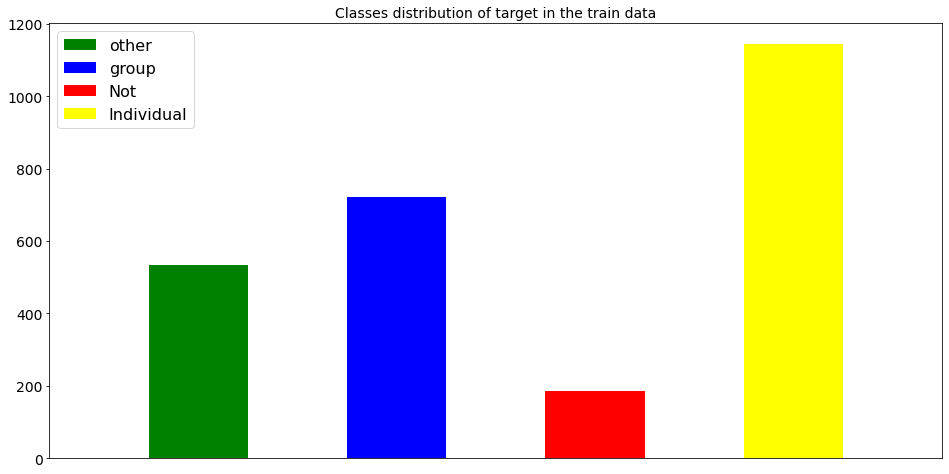

In [16]:
#plot of target
plt.hist(train_target[train_target.target == "OTHER"].target,
         bins=2, color='green', label='other')
plt.hist(train_target[train_target.target == "GROUP"].target,
         bins=2, color='blue', label='group')
plt.hist(train_target[train_target.target == "NOT"].target,
         bins=2, color='red', label='Not')
plt.hist(train_target[train_target.target == "INDIVIDUAL"].target,
         bins=2, color='yellow', label='Individual')
plt.title('Classes distribution of target in the train data')
plt.xticks([])
plt.xlim(-0.5, 4)
plt.legend()
plt.show()

In [17]:
all_reviews = np.array([], dtype=str)
df_full_exp = pd.concat(df_full_exp)
all_reviews = np.concatenate((all_reviews, df_full_exp["text"]), axis=0)
print('Total number of reviews:', len(all_reviews))
print("Percentage of NOT in the dataset:", 100/len(df_full_exp)*len(df_full_exp[df_full_exp.explicitness == "NOT"]))

Total number of reviews: 10872
Percentage of NOT in the dataset: 66.66666666666666


# Initiate Model and word Embeddings

In [18]:
# Word embeddings:

def demoModel(inputFile):
    # Let's not presume gensim installation until needed
    import gensim
    sys.stderr.write("Loading model...\n")
    model = gensim.models.KeyedVectors.load_word2vec_format(inputFile, binary=True)
    sys.stderr.write("Model loaded\n")

    return model

def downloadModel():
    """
    Download the word embeddingsmodel
    """
    modelUrl = "https://github.com/coosto/dutch-word-embeddings/releases/download/v1.0/model.bin"

    # Request model data
    try:
        request = urllib.request.Request(modelUrl)
        with urllib.request.urlopen(request) as response, open("/content/drive/MyDrive/Scriptie/code/Coosto", 'wb') as fp:
            shutil.copyfileobj(response, fp)
            sys.stderr.write("Model saved: {}\n".format(fp.name))
        return "/content/drive/MyDrive/Scriptie/code/Coosto"
    except urllib.error.HTTPError as error:
        sys.stderr.write("Error fetching model from github.com - {}\n".format(error))
        sys.stderr.write("{}".format(error.read()))
        exit(1)



In [19]:
model = downloadModel() # Download the model and test it
coosto_model = demoModel(model)
coosto_model.most_similar("pilsje")

Model saved: /content/drive/MyDrive/Scriptie/code/Coosto
Loading model...
Model loaded


[('biertje', 0.9145998954772949),
 ('glas_bier', 0.7679998874664307),
 ('wijntje', 0.7564073801040649),
 ('paar_biertjes', 0.7425606846809387),
 ('pilsjes', 0.7367861270904541),
 ('biertjes', 0.7344973087310791),
 ('colaatje', 0.7323644161224365),
 ('pilske', 0.724961519241333),
 ('borreltje', 0.7243227958679199),
 ('pils', 0.7234804630279541)]


# Build model

In [26]:
#Initialize the text versions of the data 
import numpy
x_train_text = train_exp["text"] # text of tweets
x_test_text = test_exp["text"] # text of tweets
y_test_text = test_exp["explicitness"] # Textual version of classifications (NOT, EXPLICIT, IMPLICIT)
y_train_text = train_exp["explicitness"] # Textual version of classifications (NOT, EXPLICIT, IMPLICIT)


In [30]:
def vectorize_data(data, vocab):
    """
    Returns a vectorized version of the data input with the word embeddings model called vocab
    """
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    return vectorized

In [31]:
input_length = coosto_model.vector_size # define the input length

#Vectorize and pad the sentences
print('Vectorize and pad sentences...', end='\r')
print(x_train_text[0])
x_train = pad_sequences(
    sequences=vectorize_data(x_train_text, vocab=coosto_model.wv.vocab),
    maxlen=input_length,
    padding='post') # Use X_pad to fillup the data
x_test = pad_sequences(
    sequences=vectorize_data(x_test_text, vocab=coosto_model.wv.vocab),
    maxlen=input_length,
    padding='post') # Use X_pad to fillup the data
print(x_train[0])

MENTION MENTION iets anders, wanneer word asscher voor de rechter gesleept voor het willens en wetens aan de afgrond brengen van duizende mensen door de kinderopvangtoeslagenaffaire???


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.


[1252 1039  161  964  393  385  579 1039 2217  964 1806  393  385  385
 1039 1039 2217 1806  783 2217  579  393  964  964 1247 1688 1039 2217
  681  783  783 2217  579 1039 2217 1039 1247 1688  161 1039 2217 1977
 1039  964 2228 1039 1039  809  161  681  783  783 2217 1688 1039  161
 1806 1252 2228 2228 1039  385  964 1039  385 1806 1039  161 1039  385
  964  393  393  385  579 1039  393 2941 1977 2217  783  385  579  807
 2217 1039  385 1977 1039  385  681  393  385  579  105 1252 3113 1039
  385  579 1039  446 1039  385  964 1039  385  579  783  783 2217  579
 1039  884 1252  385  579 1039 2217  783  809  681  393  385 1977  161
  783 1039  964 2228  393 1977 1039  385  393 2941 2941  393 1252 2217
 1039    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [33]:

# Factorize the dataset to 0, 1 & 2 because that is what the models need
y_test = []
y_train = []
offensiveness = ['NOT', 'EXPLICIT', 'IMPLICIT']
for row in y_test_text:
    y_test.append(offensiveness.index(row))
    
for row in y_train_text:
    y_train.append(offensiveness.index(row))


y_test = numpy.array(y_test)
y_train = numpy.array(y_train)

print(y_train[:10])
print(y_train_text[:10]) # So 0 is NOT, 1 is explicit, 2 is implicit

[2 1 2 2 2 1 2 2 2 2]
0    IMPLICIT
1    EXPLICIT
2    IMPLICIT
3    IMPLICIT
4    IMPLICIT
5    EXPLICIT
6    IMPLICIT
7    IMPLICIT
8    IMPLICIT
9    IMPLICIT
Name: explicitness, dtype: object


In [35]:
def build_bilstm_model(embedding_matrix, input_length):
    """
    Returns model: a BiLSTM model based on the word embeddings
    """
    model = Sequential()
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False))
    model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))
    model.summary()
    return model

def build_cnn_model(embedding_matrix, input_length):
    """
    Returns model: a CNN model based on the word embeddings
    """
    model = Sequential()
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False))
    model.add(Conv1D(32, 3, padding='same', activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))
    model.summary()
    return model

In [36]:
input_length = coosto_model.vector_size
# build the models
cnn_model = build_cnn_model(
    embedding_matrix=coosto_model.wv.vectors,
    input_length=input_length)

bilstm_model = build_bilstm_model(
    embedding_matrix=coosto_model.wv.vectors,
    input_length=input_length)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          75143700  
_________________________________________________________________
conv1d (Conv1D)              (None, 300, 32)           28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 150, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 4800)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 14403     
Total params: 75,186,935
Trainable params: 43,235
Non-trainable params: 75,143,700
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          75143700  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               439296    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 75,583,767
Trainable params: 440,067
Non-trainable params: 75,143,700
_________________________________________________________________


# Fit model

In [37]:
# Fit the BiLSTM model using the GPU from colab
with tf.device('/device:GPU:0'):
    bilstm_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer='adam',
        metrics=['accuracy'])

    bilstm_history = bilstm_model.fit(
        x=x_train,
        y=y_train,
        validation_data=(x_test, y_test),
        batch_size=100,
        epochs=5)

Epoch 1/5
78/78 [==============================] - 146s 2s/step - loss: 0.8924 - accuracy: 0.6420 - val_loss: 0.8570 - val_accuracy: 0.6667
Epoch 2/5
78/78 [==============================] - 118s 2s/step - loss: 0.8776 - accuracy: 0.6523 - val_loss: 0.8678 - val_accuracy: 0.6667
Epoch 3/5
78/78 [==============================] - 118s 2s/step - loss: 0.8549 - accuracy: 0.6635 - val_loss: 0.8501 - val_accuracy: 0.6667
Epoch 4/5
78/78 [==============================] - 117s 2s/step - loss: 0.8389 - accuracy: 0.6682 - val_loss: 0.8407 - val_accuracy: 0.6667
Epoch 5/5
78/78 [==============================] - 117s 1s/step - loss: 0.8351 - accuracy: 0.6609 - val_loss: 0.8324 - val_accuracy: 0.6663


In [38]:
# Fit the CNN model using the GPU from colab
with tf.device('/device:GPU:0'):
    cnn_model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam', 
                metrics=['accuracy'])
    cnn_model.summary()

    # Fitting the data onto model
    history = cnn_model.fit(
        x=x_train,
        y=y_train,
        validation_data=(x_test, y_test),
        batch_size=100,
        epochs=5)



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          75143700  
_________________________________________________________________
conv1d (Conv1D)              (None, 300, 32)           28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 150, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 4800)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 14403     
Total params: 75,186,935
Trainable params: 43,235
Non-trainable params: 75,143,700
_________________________________________________________________
Epoch 1/5
78/78 [==============================] - 30s 18ms/step - loss: 0.9370 - accuracy: 0.6316 - val_

# Evaluation

In [25]:
# print the classification report and the architecture of our BiLSTM model
pred_bilstm = bilstm_model.predict(x_test)
rounded_pred = []
for prediction in pred_bilstm:
    rounded_pred.append(prediction.argmax())
print(classification_report(list(y_test), rounded_pred))
# tf.keras.utils.plot_model(
#     bilstm_model, to_file='bilstm_model.png'
# )

              precision    recall  f1-score   support

           0       0.68      0.97      0.80      2072
           1       0.31      0.06      0.10       702
           2       0.00      0.00      0.00       334

    accuracy                           0.66      3108
   macro avg       0.33      0.34      0.30      3108
weighted avg       0.52      0.66      0.55      3108



AssertionError: ignored

In [42]:
# print the classification report and the architecture of our CNN model
pred_cnn = cnn_model.predict(x_test)
rounded_pred = []
for prediction in pred_cnn:
    rounded_pred.append(prediction.argmax())
print(classification_report(list(y_test), rounded_pred))
# tf.keras.utils.plot_model(
#     cnn_model, to_file='cnn_model.png'
# )

              precision    recall  f1-score   support

           0       0.69      0.92      0.79      2072
           1       0.39      0.11      0.17       702
           2       0.13      0.06      0.09       334

    accuracy                           0.64      3108
   macro avg       0.41      0.36      0.35      3108
weighted avg       0.56      0.64      0.57      3108



AssertionError: ignored

# Visualisation

In [44]:
def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,
                          normed=True, title='Confusion matrix'):
    """
    Prints the confusion matrix of our results
    """
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    #ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

In [45]:
y_train_pred_bilstm = bilstm_model.predict_classes(x_train)
y_test_pred_bilstm = bilstm_model.predict_classes(x_test)

y_train_pred_cnn = cnn_model.predict_classes(x_train)
y_test_pred_cnn = cnn_model.predict_classes(x_test)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


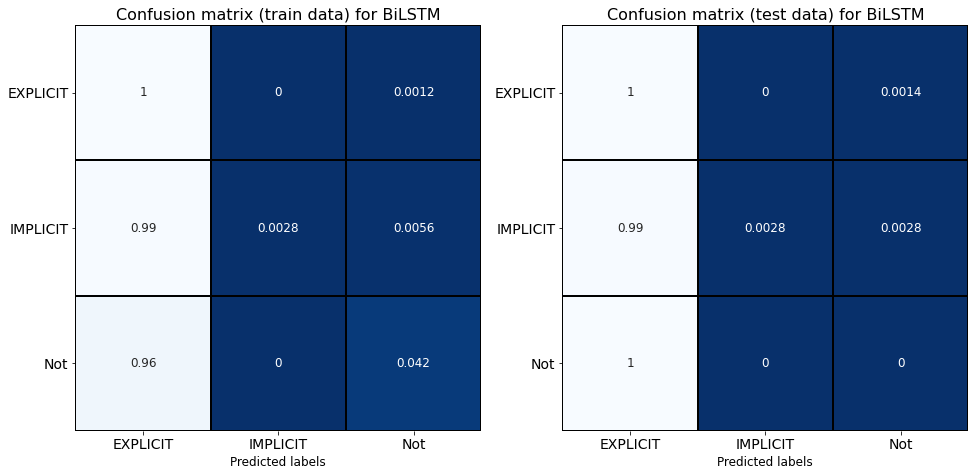

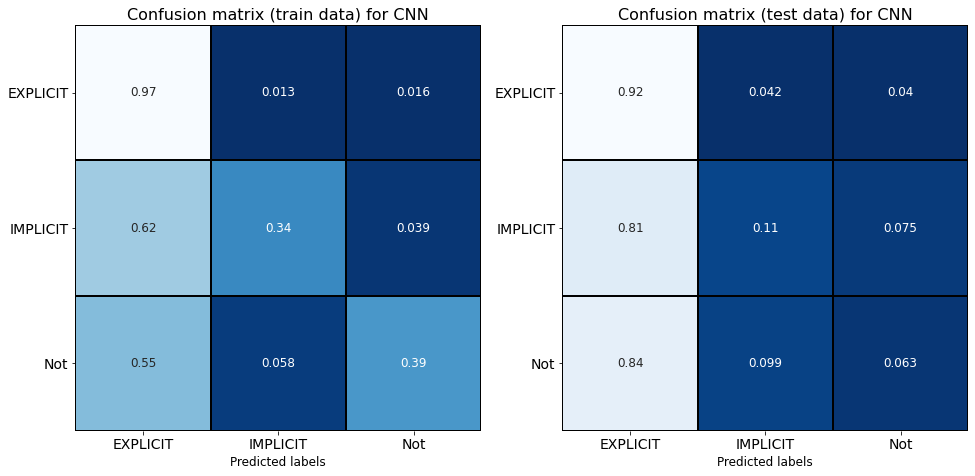

In [47]:
# Show confusion matrices
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2)
plot_confusion_matrix(y_train, y_train_pred_bilstm, ax=axis1,
                      title='Confusion matrix (train data) for BiLSTM',
                      class_names=['EXPLICIT', 'IMPLICIT', "Not"])
plot_confusion_matrix(y_test, y_test_pred_bilstm, ax=axis2,
                      title='Confusion matrix (test data) for BiLSTM',
                      class_names=['EXPLICIT', 'IMPLICIT', "Not"])

fig2, (axis3, axis4) = plt.subplots(nrows=1, ncols=2)
plot_confusion_matrix(y_train, y_train_pred_cnn, ax=axis3,
                      title='Confusion matrix (train data) for CNN',
                      class_names=['EXPLICIT', 'IMPLICIT', "Not"])
plot_confusion_matrix(y_test, y_test_pred_cnn, ax=axis4,
                      title='Confusion matrix (test data) for CNN',
                      class_names=['EXPLICIT', 'IMPLICIT', "Not"])

#BiLSTM misclassified

In [48]:
#Initialize the wrong classification dict
wrong = {
        # 'text' => ['golden', 'bilstm', 'cnn']
}

In [49]:
# Use classifier to make predicitions
pred = bilstm_model.predict(x_test)
rounded_pred = []
for prediction in pred:
    #Choose the predicition which has the highest chance according to the classifier
    rounded_pred.append(prediction.argmax())
index = 0

for pred, real in zip(rounded_pred, y_test):
    if pred != real:
        # Add all the wrong classifications to the wrong dict
        wrong[x_test_text[index]] = [real, pred, real, real]
    index += 1

#CNN misclassified

In [50]:
# Make predictions using the model
pred = cnn_model.predict(x_test)
rounded_pred = []
for prediction in pred:
    # Choose the predicition which has the highest chance according to the classifier
    rounded_pred.append(prediction.argmax())
# Initiliaze the index to find the text of the tweet 
index = 0
for pred, real in zip(rounded_pred, y_test):
    if pred != real:
        # If it is a missclassification:
        text = x_test_text[index]
        if text in wrong:
            # If the tweet was also missclassified by the BiLSTM model:
            bilstm = wrong[text] 
            bilstm[2] = pred
            wrong[text] = bilstm
        else:
            # When it did not exist yet, make a new one:
            wrong[text] = [real, real, pred, real]
    index += 1

In [ ]:
# Make a CSV file for all wrong classifications
fields = ["text", "golden", 'BiLSTM', 'CNN', 'LinearSVC']
headers = {'text','golden','BiLSTM', 'CNN', 'LinearSVC' }
with open('wrong.csv', 'w') as csv_file:
    writer = csv.writer(csv_file, delimiter='\t')
    writer.writerow(fields)
    for text, pred in wrong.items():
        row = [text, pred[0], pred[1], pred[2], pred[3]]

        writer.writerow(row)
files.download('wrong.csv')    


{'slotdebat wat een drama dat groenlinks': [1, 0, 0, 1], 'MENTION MENTION de criminele oorlogsmisdadige nato had op NUMBER maart NUMBER (één dag voor de illegale bombardementen op servië) al opgeheven moeten worden. URL': [1, 0, 2, 1], 'MENTION MENTION MENTION vind het heel dom als mensen altijd denken dat blank en donkere mensen haten .ikzelf heb dam in thailand texas rusland australië indonesië want heb negers in men familie en klikkers en vrienden uit marokko en turkye. schuld is silvana simons en die zwarten piet hater': [1, 0, 2, 1], 'die betalen niks, dat betaald de staat wel, MENTION en MENTION doen alles om de nederlanders te verdrijven en door armoede om te komen, maar miljarden naar dit soort idiote dingen. MENTION MENTION MENTION nederland is van de nederlanders! 🆘🇳🇱🌳🆘': [2, 0, 0, 2], 'MENTION goh.. moslims hebben het er maar druk mee om iedereen te bestrijden.': [2, 0, 0, 2], 'je zal toch gezellig naar een concert gaan.. godsallemachtig': [1, 0, 0, 1], 'wie gaat er nu prote

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>